# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.no_perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: XCeption
- Fractal module used: without Percolation 
- Number of layers tuned: 1

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False 
        
        self.f_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False   
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.6661
Epoch 1: val_loss improved from inf to 1.16087, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7813s 8s/step - loss: 1.1975 - accuracy: 0.6661 - val_loss: 1.1609 - val_accuracy: 0.6707
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.1748 - accuracy: 0.6681
Epoch 2: val_loss improved from 1.16087 to 1.15292, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5832s 6s/step - loss: 1.1748 - accuracy: 0.6681 - val_loss: 1.1529 - val_accuracy: 0.6751
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.1586 - accuracy: 0.6726
Epoch 3: val_loss did not improve from 1.15292
947/947 [==============================] - 7217s 8s/step - loss: 1.1586 - accuracy: 0.6726 - val_loss: 1.1662 - val_accuracy: 0.6763
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.6771
Epoch 4: val_loss improved from 1.15292 to 1.09093, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7423s 8s/step - loss: 1.1213 - accuracy: 0.6771 - val_loss: 1.0909 - val_accuracy: 0.6790
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.0903 - accuracy: 0.6769
Epoch 5: val_loss improved from 1.09093 to 1.05732, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7617s 8s/step - loss: 1.0903 - accuracy: 0.6769 - val_loss: 1.0573 - val_accuracy: 0.6813
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6788
Epoch 6: val_loss improved from 1.05732 to 1.03978, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8023s 8s/step - loss: 1.0629 - accuracy: 0.6788 - val_loss: 1.0398 - val_accuracy: 0.6813
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.0504 - accuracy: 0.6788
Epoch 7: val_loss improved from 1.03978 to 1.02432, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7962s 8s/step - loss: 1.0504 - accuracy: 0.6788 - val_loss: 1.0243 - val_accuracy: 0.6815
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.0360 - accuracy: 0.6793
Epoch 8: val_loss improved from 1.02432 to 1.02383, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8293s 9s/step - loss: 1.0360 - accuracy: 0.6793 - val_loss: 1.0238 - val_accuracy: 0.6860
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.0250 - accuracy: 0.6841
Epoch 9: val_loss improved from 1.02383 to 0.99888, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8971s 9s/step - loss: 1.0250 - accuracy: 0.6841 - val_loss: 0.9989 - val_accuracy: 0.6827
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.0158 - accuracy: 0.6854
Epoch 10: val_loss did not improve from 0.99888
947/947 [==============================] - 10153s 11s/step - loss: 1.0158 - accuracy: 0.6854 - val_loss: 1.0169 - val_accuracy: 0.6864
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.0121 - accuracy: 0.6837
Epoch 11: val_loss improved from 0.99888 to 0.97617, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9809s 10s/step - loss: 1.0121 - accuracy: 0.6837 - val_loss: 0.9762 - val_accuracy: 0.6922
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.6844
Epoch 12: val_loss did not improve from 0.97617
947/947 [==============================] - 8477s 9s/step - loss: 1.0004 - accuracy: 0.6844 - val_loss: 0.9839 - val_accuracy: 0.6904
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 0.9939 - accuracy: 0.6887
Epoch 13: val_loss did not improve from 0.97617
947/947 [==============================] - 7625s 8s/step - loss: 0.9939 - accuracy: 0.6887 - val_loss: 0.9848 - val_accuracy: 0.6867
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 0.9933 - accuracy: 0.6888
Epoch 14: val_loss did not improve from 0.97617
947/947 [==============================] - 6900s 7s/step - loss: 0.9933 - accuracy: 0.6888 - val_loss: 0.9912 - val_accuracy: 0.6863
Epoch 15/30
947/947 [===========

947/947 [==============================] - 6278s 7s/step - loss: 0.9875 - accuracy: 0.6889 - val_loss: 0.9681 - val_accuracy: 0.6899
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.6909
Epoch 16: val_loss did not improve from 0.96812
947/947 [==============================] - 5117s 5s/step - loss: 0.9825 - accuracy: 0.6909 - val_loss: 0.9760 - val_accuracy: 0.6912


### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 720s 4s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.8468980715532858,
 'basal cell carcinoma': 0.8220204445414528,
 'dermatofibroma': 0.8082610970809728,
 'melanoma': 0.7843561829448491,
 'nevus': 0.8482405399993698,
 'pigmented benign keratosis': 0.7345147615822609,
 'seborrheic keratosis': 0.7178959723251792,
 'solar lentigo': 0.8335959708317884,
 'squamous cell carcinoma': 0.816588303764689,
 'vascular lesion': 0.682087465273306}

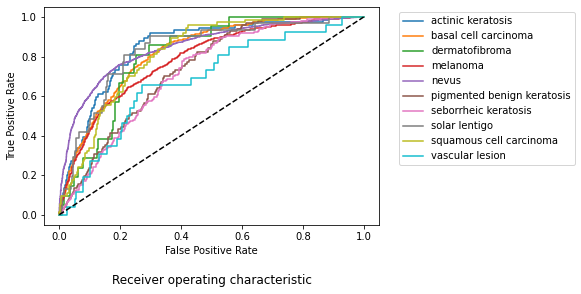

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

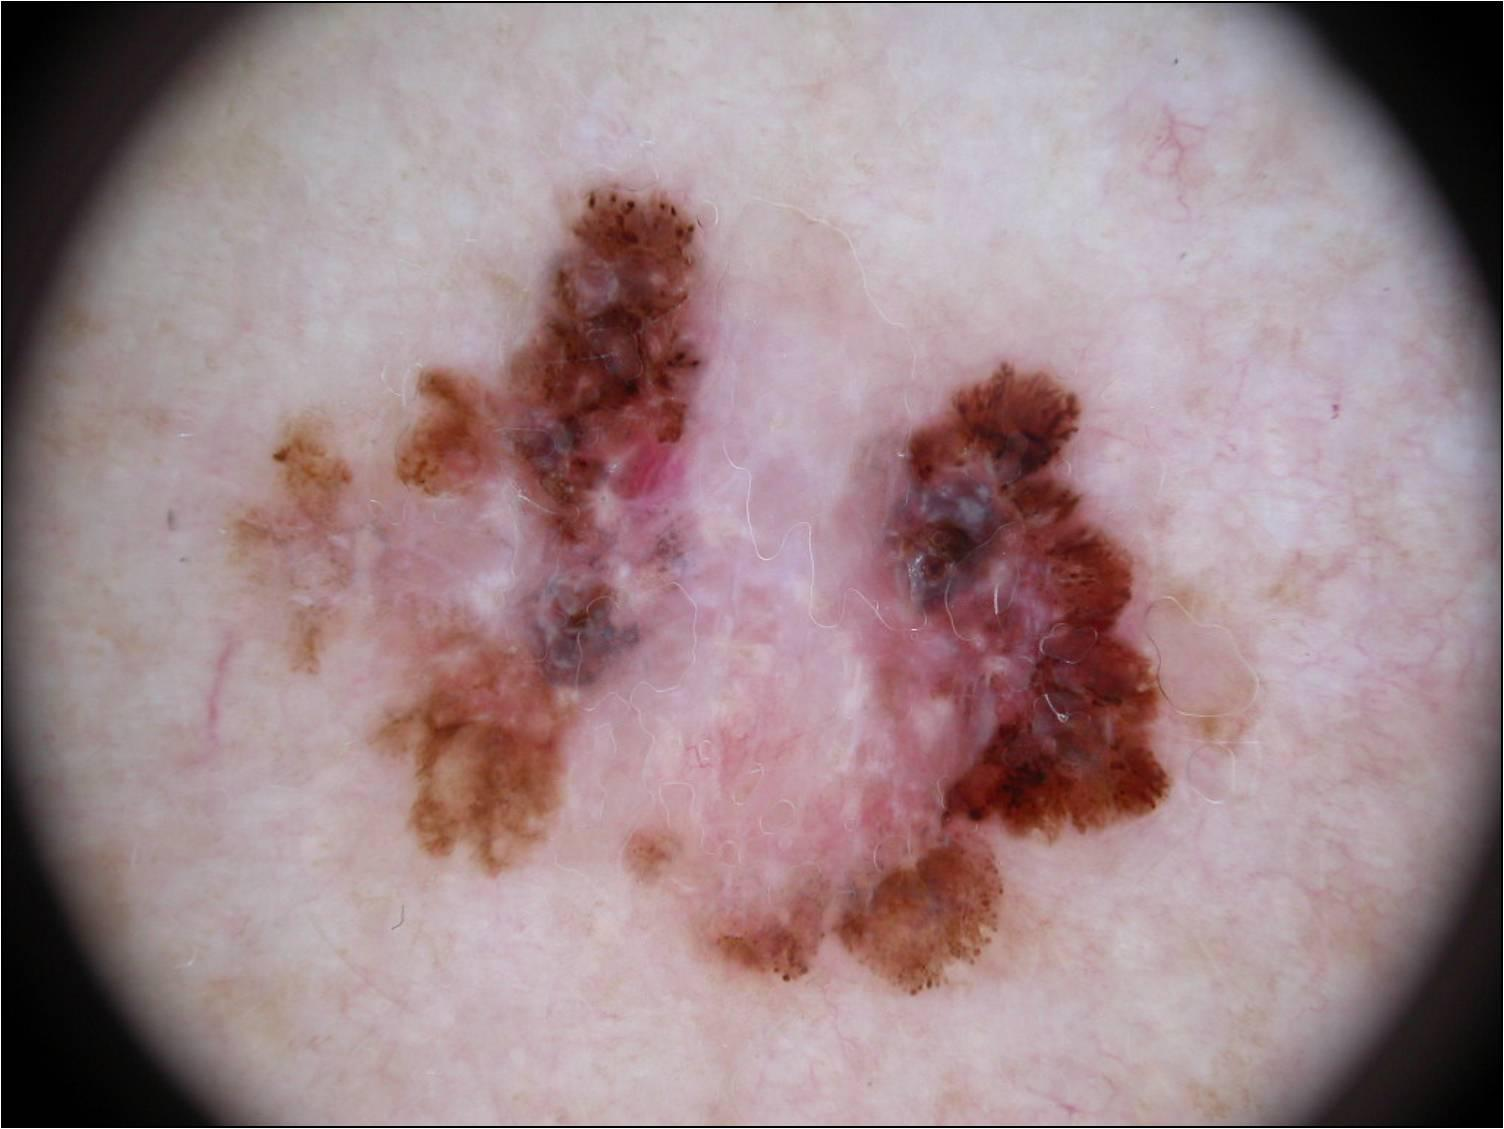

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'block14_sepconv2')

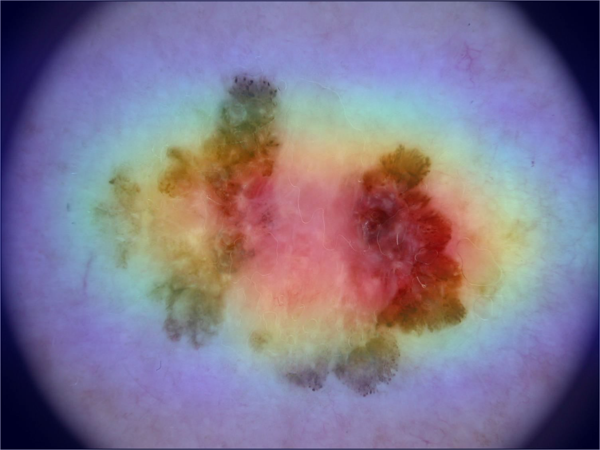

In [21]:
display_gradcam(melanoma_im_path, heatmap)